In [205]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import textacy
import numpy as np
import pandas as pd 
import json
import seaborn as sns
from sklearn.cross_validation import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Input, Merge, SpatialDropout1D, Convolution1D, MaxPooling1D, LSTM
import random
import folium
from folium import plugins
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
from scipy import sparse
from script import cf
%matplotlib inline
nlp = spacy.load('en')

# Define global variables

In [2]:
RAW_USER_JSON = './data/yelp/user.json'
RAW_TIP_JSON = './data/yelp/tip.json'
RAW_CHECKIN_JSON = './data/yelp/checkin.json'
RAW_PHOTO_JSON = './data/yelp/photos.json'
RAW_REVIEW_JSON = './data/yelp/review.json'
RAW_BUSINESS_JSON = './data/yelp/business.json'

# Take a look at data format of json files

In [3]:
def showFirst(JSON):
    f = open(JSON)
    line = json.loads(f.readline())
    df = pd.DataFrame(columns=['key','value'])
    for key, value in line.items():
        df = df.append({'key':key, 'value':value}, ignore_index=True)
    print(df)

In [4]:
showFirst(RAW_USER_JSON)

                   key                                              value
0              user_id                             oMy_rEb0UBEmMlu-zcxnoQ
1                 name                                             Johnny
2         review_count                                                  8
3        yelping_since                                         2014-11-03
4              friends  [cvVMmlU1ouS3I5fhutaryQ, nj6UZ8tdGo8YJ9lUMTVWN...
5               useful                                                  0
6                funny                                                  0
7                 cool                                                  0
8                 fans                                                  0
9                elite                                                 []
10       average_stars                                               4.67
11      compliment_hot                                                  0
12     compliment_more                

In [5]:
showFirst(RAW_TIP_JSON)

           key                                  value
0         text  Get here early enough to have dinner.
1         date                             2012-07-15
2        likes                                      0
3  business_id                 tJRDll5yqpZwehenzE2cSg
4      user_id                 zcTZk7OG8ovAmh_fenH21g


In [6]:
showFirst(RAW_CHECKIN_JSON)

           key                                              value
0         time  {'Thursday': {'21:00': 4, '1:00': 1, '4:00': 1...
1  business_id                             7KPBkxAOEtb3QeIL9PEErg


In [7]:
showFirst(RAW_PHOTO_JSON)

           key                   value
0      caption                        
1     photo_id  soK1szeyan202jnsGhUDmA
2  business_id  OnAzbTDn79W6CFZIriqLrA
3        label                  inside


In [8]:
showFirst(RAW_BUSINESS_JSON)

             key                                              value
0    business_id                             FYWN1wneV18bWNgQjJ2GNg
1           name                                   Dental by Design
2   neighborhood                                                   
3        address                           4855 E Warner Rd, Ste B9
4           city                                          Ahwatukee
5          state                                                 AZ
6    postal_code                                              85044
7       latitude                                            33.3307
8      longitude                                           -111.979
9          stars                                                  4
10  review_count                                                 22
11       is_open                                                  1
12    attributes  {'AcceptsInsurance': True, 'ByAppointmentOnly'...
13    categories  [Dentists, General Dentistry, 

In [9]:
showFirst(RAW_REVIEW_JSON)

           key                                              value
0    review_id                             v0i_UHJMo_hPBq9bxWvW4w
1      user_id                             bv2nCi5Qv5vroFiqKGopiw
2  business_id                             0W4lkclzZThpx3V65bVgig
3        stars                                                  5
4         date                                         2016-05-28
5         text  Love the staff, love the meat, love the place....
6       useful                                                  0
7        funny                                                  0
8         cool                                                  0


# Define some helper function

## Convert from json to df

In [21]:
def extract_attributes(cols, raw_json, MAX = 10 ** 10, filter = None):
    lst = []
    records = textacy.io.read_json(raw_json, mode='rt', lines=True)
    for record,_ in zip(records, range(MAX)):
        t_lst = []
        for col in cols:
            t_lst.append(record[col])            
        lst.append(t_lst)
        if _ % (10 ** 6) == 0 and _ > 0:
            print('Loading Record No: ', _)
    df = pd.DataFrame(lst, columns=cols)
    if (filter is not None):
        df = df[df.apply(filter, axis=1)]        
    return df

In [11]:
df_business = extract_attributes(cols = ['business_id','name','city'],raw_json = RAW_BUSINESS_JSON,MAX = 5)
df_business.head()

Loading Record No:  0


,business_id,name,city
0,FYWN1wneV18bWNgQjJ2GNg,Dental by Design,Ahwatukee
1,He-G7vWjzVUysIKrfNbPUQ,Stephen Szabo Salon,McMurray
2,KQPW8lFf1y5BT2MxiSZ3QA,Western Motor Vehicle,Phoenix
3,8DShNS-LuFqpEWIp0HxijA,Sports Authority,Tempe
4,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,Cuyahoga Falls


## Filter out rules for tokens

In [22]:
# define rules to filter out unuseful tokens
def filter_token(token):
    if(token.is_punct or \
       token.is_digit or \
       token.is_space or \
       token.like_num or \
       token.lemma_ == '-PRON-' or \
       token.is_stop) :
        return(False)
    else:
        return(True)

# Data Preprocessing

In [14]:
# yield entire text for one review
def generate_review():
    reviews = textacy.io.read_json(RAW_REVIEW_JSON, mode='rt', lines=True)
    for review in reviews:
        yield review['text']

In [15]:
for text in generate_review():
    print(text)
    break

Love the staff, love the meat, love the place. Prepare for a long line around lunch or dinner hours. 

They ask you how you want you meat, lean or something maybe, I can't remember. Just say you don't want it too fatty. 

Get a half sour pickle and a hot pepper. Hand cut french fries too.


## Read all business lists

In [23]:
df_business = extract_attributes(cols = ['business_id', 'latitude','longitude','city','stars','review_count', 'categories'],
                                 raw_json = RAW_BUSINESS_JSON)
print('There are a total of ', len(df_business), ' businesses in the dataset')

There are a total of  174567  businesses in the dataset


## Only study food business

Take a look at most frequent catogories

In [24]:
from collections import Counter
categoty_cnt = Counter()
for category_list in df_business['categories']:
    for category in category_list:
        categoty_cnt[category] += 1
categoty_cnt.most_common(10)

[('Restaurants', 54618),
 ('Shopping', 27971),
 ('Food', 24777),
 ('Beauty & Spas', 17014),
 ('Home Services', 16205),
 ('Health & Medical', 14230),
 ('Nightlife', 12154),
 ('Local Services', 11232),
 ('Automotive', 11052),
 ('Bars', 10563)]

Only keep three categories

In [26]:
restaurant_cate = ['Restaurants','Food','Bars']
restaurant_index = [sum([c in category_list for c in restaurant_cate])>0 for category_list in df_business['categories']]
df_restaurants = df_business.loc[ restaurant_index, ]
df_restaurants.sample(10).head()

,business_id,latitude,longitude,city,stars,review_count,categories
13882,HmnaAlLd1i38ofLnmgT2kg,43.509343,-79.631236,Mississauga,2.0,5,"[Food, Coffee & Tea]"
303,WfB_SsYeKy83QQsqAAyGVQ,36.098632,-115.136079,Las Vegas,4.5,5,"[Karaoke, Bars, Mexican, Restaurants, Nightlif..."
63140,LC2LQusE6FaRGgB5rmN6EA,36.195180,-115.257362,Las Vegas,3.5,10,"[Food, Health Markets, Specialty Food]"
76774,SZaL8OqqiQVaSeaqFnc5Cw,36.129126,-115.091280,Las Vegas,5.0,4,"[Salvadoran, Mexican, Latin American, Fast Foo..."
129066,WXPLWqJuOwPwtJa2HQ-2fA,33.466258,-112.221322,Phoenix,3.0,40,"[Restaurants, Chicken Wings]"


## Only study Toronto business

In [28]:
df_restaurants.groupby('city').agg({'business_id':'count'}).sort_values(by = 'business_id',ascending = False).head()

,business_id
city,
Toronto,9564
Las Vegas,8150
Phoenix,4934
Montréal,4223
Charlotte,3327


In [30]:
df_restaurants_trt = df_restaurants.loc[df_restaurants.city == 'Toronto']
df_restaurants_trt_id = set(list(df_restaurants_trt['business_id']))
print("There is a total of ",len(df_restaurants_trt), 'Toronto restaurants.')

There is a total of  9564 Toronto restaurants.


Export as csv

In [31]:
df_restaurants_trt.to_csv("./data/yelp/filtered_business.csv")

Confirm location on map

In [32]:
m = folium.Map([43.6532, -79.3832], zoom_start=10)
mc = MarkerCluster()
for row in df_restaurants_trt.sample(500).itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude]))
m.add_child(mc)
m

## Read Reviews for Toronto Food Business

In [59]:
df_reviews = extract_attributes(cols = ['review_id', 'business_id','stars','date'],
                                 raw_json = RAW_REVIEW_JSON,
                                 filter = lambda x: x['business_id'] in df_restaurants_trt_id)
print('There are a total of ', len(df_reviews), ' reviews for Toronto food business')

Loading Record No:  1000000
Loading Record No:  2000000
Loading Record No:  3000000
Loading Record No:  4000000
Loading Record No:  5000000
There are a total of  353394  reviews for Toronto food business


In [92]:
df_reviews.sample(100).head()
# backup = df_reviews

,review_id,business_id,stars,date
5192582,fvyqESzsI8NO-GmGXsb57g,rxA9c0_XObabVL1WCTA4FA,3,2015-09-22
2549968,3l-0XyFkmOjmJSg130h5_A,xrA53WYhRCml2bMfpQ_Hig,2,2017-08-12
3523023,1DUWyKnLRrLGKmQMiRk_8Q,DlFKsdGY7-7c4u7_A-W99Q,3,2015-07-14
4320285,qRPd0XT-qql64nZNFwg6kA,549qudovfSh00D2uj64D8A,4,2013-03-01
2382619,XP1fKD7_hslUuBXL4i2GTQ,SILSPO3t7JEMJvDjDPTOag,1,2015-04-18


## Number of Reviews by Date

In [162]:
%%time
df_reviews['date'] = pd.to_datetime(df_reviews['date'])
date_summary = df_reviews.groupby(df_reviews['date'].\
                        dt.to_period("M")).\
                        agg({'review_id':'count', 'stars': 'mean'}).reset_index()
date_summary.head(2)

CPU times: user 5.62 s, sys: 493 ms, total: 6.11 s
Wall time: 5.27 s


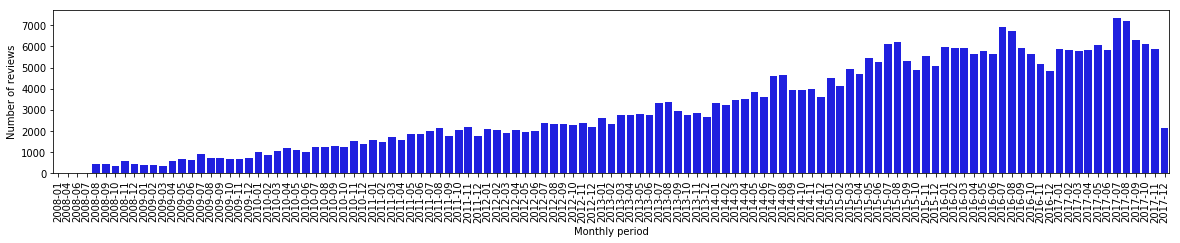

In [163]:
f, ax = plt.subplots(figsize=(20, 3))
g = sns.barplot(x="date", y="review_id",data=date_summary,color="b")
plt.xlabel('Monthly period')
plt.ylabel('Number of reviews')
plt.xticks(rotation=90)
plt.show()

## Only keep reviews later than 2012

In [164]:
df_reviews = df_reviews.loc[df_reviews.date.dt.year >= 2012, :]

## Number of Reviews by Business

In [165]:
rf = df_reviews['business_id'].value_counts()
rf.quantile([0.05,0.1,0.2,0.3,0.4,0.5])

0.05     2.0
0.10     3.0
0.20     4.0
0.30     6.0
0.40     9.0
0.50    13.0
Name: business_id, dtype: float64

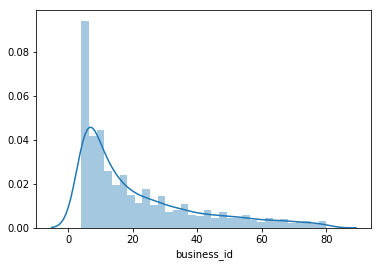

In [166]:
review_by_business_freq = rf[(rf>rf.quantile(0.10)) & (rf<rf.quantile(0.90))]
sns.distplot(review_by_business_freq)

In [169]:
business_id_with_30_plus_reviews = set(rf[rf >= 30].index)
print('There is a total of', str(len(business_id_with_30_plus_reviews)), 'Toronto restaurants with more than 30 reviews')

There is a total of 2707 Toronto restaurants with more than 30 reviews


## Only keep reviews for business with more than 30 reviews

In [170]:
%%time
df_reviews = extract_attributes(cols = ['user_id', 'business_id','stars','date','text'],
                                 raw_json = RAW_REVIEW_JSON, 
                                 filter = lambda x: x['business_id'] in business_id_with_30_plus_reviews)
print('There is a total of ', len(df_reviews), 'reviews in the filtered review set')

Loading Record No:  1000000
Loading Record No:  2000000
Loading Record No:  3000000
Loading Record No:  4000000
Loading Record No:  5000000
There is a total of  271338 reviews in the filtered review set
CPU times: user 1min 54s, sys: 14.9 s, total: 2min 8s
Wall time: 2min 11s


In [171]:
backup_2 = df_reviews

##  Distribution of Rating

Scewed towards higher scores

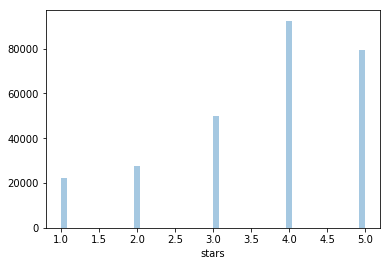

In [188]:
sns.distplot(df_reviews.stars.dropna(), kde=False)

## Number of Reviews by User

In [189]:
date_summary = df_reviews.groupby(df_reviews['user_id']).agg({'text':'count', 'stars': 'mean'}).reset_index()
date_summary.columns = ['user_id','count','stars']

In [190]:
date_summary.sort_values(by = "count", ascending = False).head()

,user_id,count,stars
14533,CxDOIDnH8gp9KXzpBHJYXw,669,3.390135
28356,Q9mA60HnY87C1TW5kjAZ6Q,367,4.065395
17120,FREeRQtjdJU83AFtdETBBw,355,4.177465
31983,TbhyP24zYZqZ2VJZgu1wrg,345,3.452174
1231,0BBUmH7Krcax1RZgbH4fSA,327,3.608563


In [191]:
review_count_by_user = date_summary['count']
review_count_by_user.describe()

count    67019.000000
mean         4.048673
std         10.884396
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        669.000000
Name: count, dtype: float64

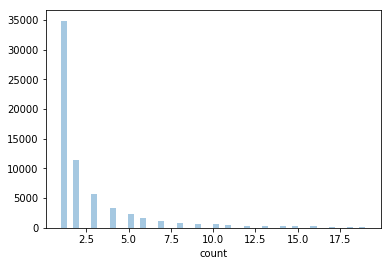

In [192]:
sns.distplot(review_count_by_user[review_count_by_user < 20], kde=False)

## Only keep users with more than 10 reviews

In [193]:
user_id_10_plus = set(date_summary.loc[date_summary['count']>=10, 'user_id'])
print('There is a total of', str(len(user_id_10_plus)), ' users with more than 10 reviews')

There is a total of 5146  users with more than 10 reviews


In [194]:
df_reviews = df_reviews[df_reviews.user_id.isin(user_id_10_plus)] 
print('There are a total of ', str(len(df_reviews)), ' reviews after filtering')

There are a total of  141186  reviews after filtering


Export as csv

In [195]:
df_reviews.to_csv('./data/yelp/filtered_review.csv', index=False)

## Prepare user-business matrix

Re-code user_id and business_id

In [237]:
user_labels, user_uniques = pd.factorize(df_reviews.user_id)
busi_labels, busi_uniques = pd.factorize(df_reviews.business_id)
df_reviews.user_id = user_labels
df_reviews.business_id = busi_labels
n_users = len(user_uniques)
n_busi  = len(busi_uniques)
print ('Number of users = ' , str(n_users) + ' | Number of businesses = ', str(n_busi))

Number of users =  5146 | Number of businesses =  2707


In [238]:
df_reviews.head(2)

,user_id,business_id,stars,date,text
7,0,0,4,2012-05-11,Who would have guess that you would be able to...
8,0,1,4,2015-10-27,Always drove past this coffee house and wonder...


Generate user-business matrix

In [250]:
matrix_reviews = np.zeros((n_users, n_busi))
for line in df_reviews.itertuples():
    matrix_reviews[line[1], line[2]] = line[3]
matrix_reviews.shape

(5146, 2707)

In [251]:
print('There is a total of ', sum(sum(matrix_reviews > 0)), ' Ratings in the matrix')

There is a total of  141186  Ratings in the matrix


In [252]:
print('Sparsity: ', sum(sum(matrix_reviews == 0))/ (n_users * n_busi) * 100, '%')

Sparsity:  98.98647702814787 %


## Split training and validation set

In [263]:
random.seed(1)
val_user_ids = random.sample(range(n_users), int(n_users / 2))
val_busi_ids = random.sample(range(n_busi),  int(n_busi/ 2))

In [264]:
val_idx = (df_reviews.user_id.isin(val_user_ids)) & (df_reviews.business_id.isin(val_busi_ids))
df_reviews_train = df_reviews[~val_idx]
df_reviews_val   = df_reviews[val_idx]
print('There is a total of ', len(df_reviews_train), 'training data')
print('There is a total of ', len(df_reviews_val), 'validation data')

There is a total of  106852 training data
There is a total of  34334 validation data


In [265]:
matrix_reviews_train = np.copy(matrix_reviews)
matrix_reviews_val   = np.zeros_like(matrix_reviews)

In [266]:
for i in val_user_ids:
    for j in val_busi_ids:
        matrix_reviews_val[i,j] = matrix_reviews[i,j]
        matrix_reviews_train[i,j] = 0

In [267]:
print('There is a total of ', sum(sum(matrix_reviews_val >0)), ' valid ratings in the matrix to be predicted')

There is a total of  34334  valid ratings in the matrix to be predicted


# Collaborating Filtering - Memory-based

## Define Similarity

In [268]:
def cosine_similarities(mat):
    col_normed_mat = pp.normalize(mat.tocsc(), axis=0)
    return col_normed_mat.T * col_normed_mat

In [269]:
matrix_reviews_sp = sparse.csr_matrix(matrix_reviews_train)
matrix_reviews_sp.shape

(5146, 2707)

In [270]:
user_similarity = cosine_similarities(matrix_reviews_sp.T)
user_similarity.shape

(5146, 5146)

In [271]:
item_similarity = cosine_similarities(matrix_reviews_sp)
item_similarity.shape

(2707, 2707)

# Calculate prediction

In [101]:
ui_predictions = cf.ui_predict(matrix_reviews, np.array(user_similarity.todense()))
ui_predictions.shape

(5876, 4835)

In [102]:
ii_predictions = cf.ii_predict(matrix_reviews, np.array(item_similarity.todense()))
ii_predictions.shape

(5876, 4835)

In [109]:
from sklearn.metrics import mean_squared_error


0.0

TBA: Evaluation

# Collaborative Filtering - Matrix Factorization

In [104]:
from scipy.sparse.linalg import svds

In [146]:
u, s, vt = svds(matrix_reviews, k = 20)
s_diag_matrix = np.diag(s)
mf_prediction = np.dot(np.dot(u, s_diag_matrix), vt)

TBA: Evaluation

# Content-based Filtering

# Phrase Model

In [138]:
MAX_NUM = 10 ** 10 # number of records for testing
review_texts = df_reviews.text
len(review_texts)

78790

## Prepare Sentence (tokens) List

- Process
    1. filter out based on rules
    2. lemmatize
    
    
- Output:  
**[**<br/>
[sentence 1 token 1, sentence 1 token 2], ..., [sentence 1 token K1],<br/>
[sentence 2 token 1, sentence 2 token 2], ..., [sentence 2 token K2],<br/>
...<br/>
[sentence N token 1, sentence N token 2], ..., [sentence N token KN]<br/>
**]**

In [ ]:
def generate_list(all_reviews, max_num = MAX_NUM):
    df = []
    
    for doc,_ in zip(nlp.pipe(all_reviews, batch_size=128, n_threads=-1), # parallel processing
                     range(max_num)):                                     # only MAX_NUM files
        if _ % 1000 == 0:
            print('Processing Record No: ', _)
        for sent in doc.sents:
            df.append( [token.lemma_ for token in sent if filter_token(token)]) 
    return(df)

In [126]:
unigram_sentences = generate_list(all_reviews = review_texts.sample(1000))
len(unigram_sentences) # Number of sentences

Processing Record No:  0


10176

In [127]:
unigram_sentences[:5]

[['this', 'place', 'leave', 'bit', 'conflicted'],
 ['the',
  'service',
  'good',
  'like',
  'feel',
  'restaurant',
  'traditional',
  'vietnamese',
  'restaurant'],
 ['have', 'try', 'oxtail', 'pho', 'restaurant', 'know'],
 ['the', 'broth', 'delicious'],
 ['overall', 'not', 'feel', 'get', 'bang', 'buck', 'like', 'pho']]

## Train phrase model

In [128]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [129]:
bigram_model = Phraser(Phrases(unigram_sentences))
trigram_model = Phraser(Phrases(bigram_model[unigram_sentences]))

## Apply Phrase Model

- Process
    1. filter out based on rules
    2. lemmatize
    3. apply bigram and trigram phrase model


- Output:  
**[**<br/>
[Doc 1 token 1, Doc 1 token 2], ..., [Doc 1 token K1],<br/>
[Doc 2 token 1, Doc 2 token 2], ..., [Doc 2 token K2],<br/>
...<br/>
[Doc N token 1, Doc N token 2], ..., [Doc N token KN]<br/>
**]**

In [139]:
def apply_phrase_model(all_reviews, max_num = MAX_NUM):
    df = []
    
    for doc,_ in zip(nlp.pipe(all_reviews, batch_size=128, n_threads=-1),
                   range(max_num)):
        if _ % 1000 == 0:
            print('Processing Record No: ', _)
        unigram_review =  [token.lemma_ for token in doc if filter_token(token)]
        bigram_review = bigram_model[unigram_review]
        #trigram_review = trigram_model[bigram_review]
        df.append(bigram_review)
    return(df)

In [140]:
phrased_reviews = apply_phrase_model(all_reviews = review_texts)
len(phrased_reviews)

Processing Record No:  0
Processing Record No:  1000
Processing Record No:  2000
Processing Record No:  3000
Processing Record No:  4000
Processing Record No:  5000
Processing Record No:  6000
Processing Record No:  7000
Processing Record No:  8000
Processing Record No:  9000
Processing Record No:  10000
Processing Record No:  11000
Processing Record No:  12000
Processing Record No:  13000
Processing Record No:  14000
Processing Record No:  15000
Processing Record No:  16000
Processing Record No:  17000
Processing Record No:  18000
Processing Record No:  19000
Processing Record No:  20000
Processing Record No:  21000
Processing Record No:  22000
Processing Record No:  23000
Processing Record No:  24000
Processing Record No:  25000
Processing Record No:  26000
Processing Record No:  27000
Processing Record No:  28000
Processing Record No:  29000
Processing Record No:  30000
Processing Record No:  31000
Processing Record No:  32000
Processing Record No:  33000
Processing Record No:  3400

78790

Take a look at bi- and tri- grams

In [141]:
' / '.join([word for phrased_review in phrased_reviews for word in phrased_review if '_' in word ][:15])

'banh_mi / large_group / menu_item / menu_item / milk_tea / menu_item / milk_tea / taste_like / definitely_return / gluten_free / onion_ring / lunch_special / taste_like / menu_item / noodle_soup'

In [145]:
pd.DataFrame({'Text':phrased_reviews}).to_csv('./data/yelp/phrased_review_text.csv',index=False)

# TF-IDF

In [152]:
review_corpus = [' '.join(phrased_review) for phrased_review in phrased_reviews]
review_corpus[0]

'great place chinatown banh_mi just sure know want crazy hectic the lady counter harass lot great prepacked food sandwich not thing'

In [154]:
len(review_corpus)

78790

In [163]:
# DIRECTLY from corpus to tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 10000)
review_tfidf=vectorizer.fit_transform(review_corpus)
review_tfidf.toarray().shape

(78790, 10000)

In [164]:
vectorizer.vocabulary_['great']

3924

# Topic Modelling - `gensim`

<img src="https://s3.amazonaws.com/skipgram-images/LDA.png" width= 400>

In [210]:
from gensim import corpora
from gensim.models import LdaMulticore
import pyLDAvis.gensim as gensimvis
import pyLDAvis

Create gensim `dictionary`

In [211]:
dictionary = corpora.Dictionary(phrased_reviews)
print(dictionary)

Dictionary(31197 unique tokens: ['ask', 'cut', 'fatty', 'french_fry', 'get']...)


An example of using dictionary (essentially just document-term matrix)

In [212]:
dictionary.doc2bow(phrased_reviews[300])

[(19, 1),
 (57, 1),
 (77, 1),
 (78, 1),
 (89, 2),
 (91, 1),
 (99, 2),
 (138, 1),
 (230, 1),
 (249, 1),
 (328, 1),
 (530, 1),
 (968, 1),
 (1200, 1),
 (1384, 1),
 (1471, 1),
 (1771, 1),
 (3740, 1),
 (3741, 1),
 (3742, 1),
 (3743, 1)]

Create gensim `corpus`

In [213]:
corpus = [dictionary.doc2bow(phrased_review) for phrased_review in phrased_reviews]
corpora.MmCorpus.serialize('./model/yelp_gensim_corpus.mm', corpus)  # store to disk, for later use
corpus = corpora.MmCorpus('./model/yelp_gensim_corpus.mm')

Train LDA model

In [214]:
lda = LdaMulticore(corpus, 
                   num_topics = 5, 
                   id2word = dictionary, 
                   workers = 3)

Take a look at top terms in first topic

In [215]:
lda.show_topic(0, topn=10)

[('not', 0.014495503),
 ('the', 0.013054001),
 ('be', 0.011199601),
 ('great', 0.010389214),
 ('place', 0.009433869),
 ('food', 0.008967895),
 ('come', 0.007817965),
 ('good', 0.0076900036),
 ('like', 0.0074591003),
 ('time', 0.0066083395)]

Visualization

In [216]:
vis_data  = gensimvis.prepare(lda, corpus, dictionary)

/Users/shiwang/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [217]:
pyLDAvis.display(vis_data)

# Topic Modeling - `textacy`

Create Document-Term Matrix

In [218]:
vectorizer = textacy.vsm.Vectorizer(tf_type='linear', min_df = 1)
doc_term_matrix = vectorizer.fit_transform(phrased_reviews)
doc_term_matrix

<10000x31197 sparse matrix of type '<class 'numpy.int32'>'
	with 496916 stored elements in Compressed Sparse Row format>

Train Topic Model

In [219]:
model = textacy.tm.TopicModel('lda', n_topics=5) 
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

/Users/shiwang/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


(10000, 5)

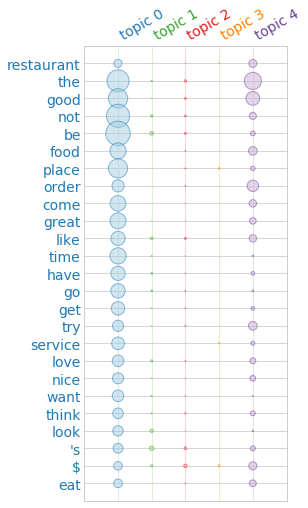

In [220]:
model.termite_plot(doc_term_matrix,  
                   vectorizer.id_to_term,
                   highlight_topics=[0,1,2,3,4])

# Predict review stars

## Prepare constant length reviews

/Users/shiwang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


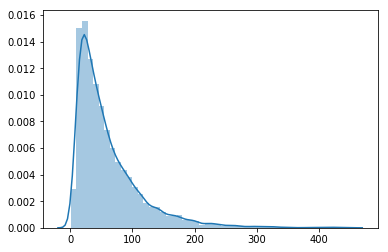

In [221]:
sns.distplot([len(review) for review in phrased_reviews])

In [222]:
def pad_trim_review(review, MAX_LEN = 50):
    l = len(review)
    if  l >= MAX_LEN:
        return(review[:MAX_LEN])
    else:
        return(review + ['<PAD/>'] * (MAX_LEN - l))

In [223]:
pad_trim_review(phrased_reviews[0])[:5],pad_trim_review(phrased_reviews[0])[-5:]

(['love', 'staff', 'love', 'meat', 'love'],
 ['<PAD/>', '<PAD/>', '<PAD/>', '<PAD/>', '<PAD/>'])

## Generate index-based input

In [224]:
dictionary = corpora.Dictionary(phrased_reviews)
phrased_reviews_padded = [pad_trim_review(x) for x in phrased_reviews]
phrased_reviews_padded_index = [dictionary.doc2idx(x, unknown_word_index=len(dictionary)) for x in phrased_reviews_padded]

In [225]:
VOCAB_SIZE = len(dictionary) + 1
VOCAB_SIZE

31198

In [226]:
phrased_reviews_padded_index[0][:5], phrased_reviews_padded_index[0][-5:]

([12, 22, 12, 15, 12], [31197, 31197, 31197, 31197, 31197])

In [227]:
phrased_reviews_padded_index = np.array(phrased_reviews_padded_index)
phrased_reviews_padded_index.shape

(10000, 50)

## Extract target

In [228]:
def generate_stars():
    reviews = textacy.io.read_json(RAW_REVIEW_JSON, mode='rt', lines=True)
    for review in reviews:
        yield(review['stars'])

In [229]:
stars = [star for star, _ in zip(generate_stars(), range(MAX_NUM))]
stars[:5]

[5, 5, 5, 5, 4]

In [230]:
stars = np.array(stars).reshape(-1,1)
stars.shape

(10000, 1)

/Users/shiwang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


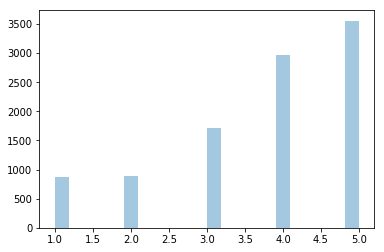

In [231]:
sns.distplot(stars,kde=False)

## Generate Training and Testing set

In [279]:
data = np.append(phrased_reviews_padded_index, stars,axis = 1) # continous
data.shape

(10000, 51)

In [274]:
data = np.append(phrased_reviews_padded_index, stars,axis = 1) #binary
data = data[data[:,-1] != 3]
data[:,-1] = [0 if x < 3 else 1 for x in data[:,-1]]
data.shape

(8284, 51)

In [280]:
random.seed(1)
np.random.shuffle(data)
train, test = train_test_split(data, test_size = 0.15,random_state = 0)
X_train = train[:,:-1]
X_test = test[:,:-1]
Y_train = train[:,-1]
Y_test = test[:,-1]

## Define LSTM network

In [281]:
MAX_LEN = 50
VOCAB_SIZE
embedding_dim = 25
lstm_units = 120
batch_size = 64

In [282]:
model = Sequential()
model.add(Embedding(input_dim = VOCAB_SIZE, 
                    output_dim = embedding_dim, 
                    input_length = MAX_LEN))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(units = lstm_units, 
               dropout = 0.2,  
               recurrent_dropout = 0.2))
model.add(Dense(60, activation='relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(1, activation='relu')) # continous
#model.add(Dense(1, activation='sigmoid')) # binary
model.summary()

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 50, 25)            779950    
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 50, 25)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 120)               70080     
_________________________________________________________________
dense_15 (Dense)             (None, 60)                7260      
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 61        
Total params: 857,351
Trainable params: 857,351
Non-trainable params: 0
_________________________________________________________________


/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


## Model training

In [278]:
model.compile(loss='binary_crossentropy', 
              optimizer = optimizers.Adam(lr=0.001), 
              metrics=['accuracy'])
model.fit(X_train, 
          Y_train, 
          batch_size = batch_size, 
          validation_data=(X_test, Y_test), 
          epochs = 10)

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

Train on 7041 samples, validate on 1243 samples
Epoch 1/10
7041/7041 [==============================] - 10s 1ms/step - loss: 0.5405 - acc: 0.7823 - val_loss: 0.4969 - val_acc: 0.7916
Epoch 2/10
7041/7041 [==============================] - 7s 1ms/step - loss: 0.4128 - acc: 0.8350 - val_loss: 0.4094 - val_acc: 0.8648
Epoch 3/10
7041/7041 [==============================] - 7s 1ms/step - loss: 0.2646 - acc: 0.9068 - val_loss: 0.3203 - val_acc: 0.8850
Epoch 4/10
7041/7041 [==============================] - 7s 1ms/step - loss: 0.1965 - acc: 0.9359 - val_loss: 0.3240 - val_acc: 0.8954
Epoch 5/10
7041/7041 [==============================] - 7s 1ms/step - loss: 0.1357 - acc: 0.9565 - val_loss: 0.3098 - val_acc: 0.8817
Epoch 6/10
7041/7041 [==============================] - 7s 1ms/step - loss: 0.1029 - acc: 0.9692 - val_loss: 0.3255 - val_acc: 0.8914
Epoch 7/10
7041/7041 [==============================] - 7s 963us/step - loss: 0.0807 - acc: 0.9768 - val_loss: 0.3245 - val_acc: 0.8825
Epoch 8/10


In [283]:
model.compile(loss='mean_squared_error', 
              optimizer= optimizers.Adam(lr=0.001), 
              metrics=['mae'])
model.fit(X_train, 
          Y_train, 
          batch_size = batch_size, 
          validation_data=(X_test, Y_test), 
          epochs = 10)

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/shiwang/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfu

Train on 8500 samples, validate on 1500 samples
Epoch 1/10
8500/8500 [==============================] - 11s 1ms/step - loss: 3.4113 - mean_absolute_error: 1.4562 - val_loss: 1.5131 - val_mean_absolute_error: 0.9669
Epoch 2/10
8500/8500 [==============================] - 8s 995us/step - loss: 2.0851 - mean_absolute_error: 1.1789 - val_loss: 1.4755 - val_mean_absolute_error: 1.0007
Epoch 3/10
8500/8500 [==============================] - 8s 976us/step - loss: 2.0436 - mean_absolute_error: 1.1654 - val_loss: 1.4726 - val_mean_absolute_error: 1.0302
Epoch 4/10
8500/8500 [==============================] - 8s 979us/step - loss: 1.7889 - mean_absolute_error: 1.0782 - val_loss: 1.1768 - val_mean_absolute_error: 0.8571
Epoch 5/10
8500/8500 [==============================] - 8s 989us/step - loss: 1.5029 - mean_absolute_error: 0.9856 - val_loss: 1.1340 - val_mean_absolute_error: 0.8390
Epoch 6/10
8500/8500 [==============================] - 9s 1ms/step - loss: 1.2611 - mean_absolute_error: 0.8955 